In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(suppress=True)
import pickle
import sys, os
import time
import libcamodocal
import matplotlib.pyplot as plt
import cv2
import quaternion
from IPython import display
from IPython.display import clear_output
import glob
import calib_utils
import calib
import geo_utils

In [2]:
# define cb pattern
checker_data = {"cb_pattern": (5,6), "cb_size": .04}


# load calib data
calib_data = pickle.load( open("/home/ralfi/Desktop/calibdata_30_04_2022_14_21_57.pkl", "rb" ))

rgbs = calib_data['rgb']
poses_urx = calib_data['poses']
    
# Setup Camera intrinsics
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001)

## HARDCODED CAM APRAMS 
# Setup Camera intrinsics
K = calib_data['intr']
dist = np.zeros((5,1))
print(K)

print(K)
print(np.transpose(dist))

#Setup HEC Solver
setup = calib.calibrator.Setup(2)
cgi_cal = calib.calibrator.HandEyeCalibrator(setup)

[[644.39996338   0.         639.5       ]
 [  0.         644.39996338 359.5       ]
 [  0.           0.           1.        ]]
[[644.39996338   0.         639.5       ]
 [  0.         644.39996338 359.5       ]
 [  0.           0.           1.        ]]
[[0. 0. 0. 0. 0.]]


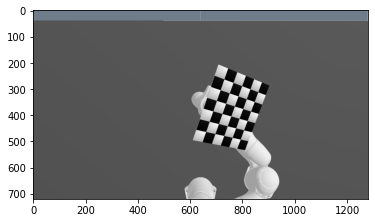

In [3]:
plt.imshow(rgbs[0][0])

In [4]:
N = len(rgbs)

#Setup HEC Solver
setup = calib.calibrator.Setup(2)
cgi_cal = calib.calibrator.HandEyeCalibrator(setup)

# Setup Marker
marker_type = 'charuco'
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
board = cv2.aruco.CharucoBoard_create(7, 6, 0.04, 0.031, aruco_dict)

# lists for graph hand eye
list_points_2d, obj_poses, obj_poses_inv, hand_poses, hand_poses_inv = [], [], [], [], []

for i in range(N):
    
    frames = np.array(rgbs[i])
    #frames = np.array(rgbs[i][0])
    #calculate cam_pose
    
    #p_tvec_median, p_rvec_median, homTF_obj, corners_median, c_corner_median, points_2d_median, imgs = calib_utils.estimate_cam_pose_charuco(frames, K, dist, board, aruco_dict, debug = False)
    p_tvec_median, p_rvec_median, obj_homTF, corner_img_all, corner_img_all = calib_utils.estimate_cam_pose_checker(frames, K, dist, checker_data, dist, criteria, debug = True)
    if(len(p_tvec_median)==0 and len(p_rvec_median)==0):
        continue
    
    #review and skip 
    if False:
        if (not calib_utils.review_img(corner_img_all[0])):
            continue
        
    
    #calculate hand psoe
    pose_homTF = geo_utils.pose7d2homTF(poses_urx[i][0])
    pose_homTF_inv = np.linalg.inv(pose_homTF)
    obj_homTF_inv = np.linalg.inv(obj_homTF)
        
    if True:
        obj_poses.append(obj_homTF)
        obj_poses_inv.append(obj_homTF_inv)
        hand_poses.append(pose_homTF)
        hand_poses_inv.append(pose_homTF_inv)
    
        cgi_cal.add_sample(pose_homTF_inv, obj_homTF)

In [13]:
# MAIN
import camera_calib_utils

np.set_printoptions(suppress=True)

allCorners, objectPointsArray, imsize = camera_calib_utils.read_checker_board(rgbs, checker_data)
    
%time ret, mtx, dist, rvecs, tvecs =  camera_calib_utils.calibrate_checker_camera(allCorners, objectPointsArray, imsize, init_guess = False)


print(mtx)
    

CPU times: user 155 ms, sys: 0 ns, total: 155 ms
Wall time: 159 ms
[[1831.05111313    0.          434.7039792 ]
 [   0.         1573.26811562  484.91770436]
 [   0.            0.            1.        ]]


In [5]:
dani = cgi_cal.solve(calib.solver.Daniilidis1999)
print("dani\n", dani)

tsai = cgi_cal.solve(calib.solver.TsaiLenz1989)
print("tsai\n", tsai)

park = cgi_cal.solve(calib.solver.ParkBryan1994)
print("park\n", park)

dani
 [[ 0.00725767 -0.99997329 -0.000868    0.49915179]
 [-0.99997363 -0.00725789  0.00025873  0.00002337]
 [-0.00026503  0.0008661  -0.99999959  0.9994181 ]
 [ 0.          0.          0.          1.        ]]
tsai
 [[ 0.11589346 -0.99256884 -0.0370919   0.49510894]
 [-0.99325926 -0.1158942  -0.00213744  0.00698673]
 [-0.00217718  0.03708959 -0.99930957  0.99024014]
 [ 0.          0.          0.          1.        ]]
park
 [[ 0.00606003 -0.99998164 -0.00001844  0.49936141]
 [-0.99998148 -0.00606001 -0.00057041  0.00158388]
 [ 0.00057028  0.0000219  -0.99999984  1.00571926]
 [ 0.          0.          0.          1.        ]]


In [6]:
print("dani\n", geo_utils.homTF2pose7d(dani))

print("tsai\n", geo_utils.homTF2pose7d(tsai))

print("park\n", geo_utils.homTF2pose7d(park))


dani
 [ 0.49915179  0.00002337  0.9994181  -0.00021396 -0.70966808  0.70453602
  0.00039914]
tsai
 [ 0.49510894  0.00698673  0.99024014 -0.01313095 -0.7468429   0.66474091
  0.01314503]
park
 [ 0.49936141  0.00158388  1.00571926 -0.00020878 -0.70924606  0.70496096
 -0.00019452]


In [6]:
geo_utils.pose7d2homTF(calib_data['ground_truth']) - dani

array([[-0.00725767, -0.00002671,  0.000868  ,  0.00084821],
       [-0.00002637,  0.00725789, -0.00025873, -0.00002337],
       [ 0.00026503, -0.0008661 , -0.00000041,  0.0005819 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [8]:
lol = libcamodocal.py_camodocal_calibration(hand_poses, obj_poses, {}, False)
print(lol)

[[-0.38981148 -0.44724611  0.80499561  0.74739815]
 [ 0.47263134  0.65307208  0.59170641  0.15373014]
 [-0.79035855  0.6111201  -0.04319247  0.2593431 ]
 [ 0.          0.          0.          1.        ]]


In [9]:
np.linalg.inv(lol)

array([[-0.38981148,  0.47263134, -0.79035855,  0.42366074],
       [-0.44724611,  0.65307208,  0.6111201 ,  0.07538427],
       [ 0.80499561,  0.59170641, -0.04319247, -0.68141367],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [10]:
# generate pattern_3d
cb_pattern = (5, 6)
pattern_3d = np.zeros((np.prod(cb_pattern), 3), np.float32)
pattern_3d[:, :2] = np.indices(cb_pattern).T.reshape(-1, 2)
pattern_3d *= cb_size
pattern_3d = np.transpose(pattern_3d)

In [11]:
# setup pars
params={}
params['pattern2d_inf_scale'] = 1e-6
params['world2hand_inf_scale_trans'] = 1e-6
params['world2hand_inf_scale_rot'] = 1
params['num_iterations'] = 1000*8192
params['solver_name'] = "lm_var_cholmod"
params['robust_kernel_handpose'] = "Huber"
params['robust_kernel_projection'] = "Huber"
params['robust_kernel_handpose_delta'] = 1e-6
params['robust_kernel_projection_delta'] = 1e-6

init_object2world = np.eye(4)

init_hand2eye = park

#hand2eye_visp, object2world_visp = cb.py_spatial_calibration_graph(K, pattern_3d, list_hand_pose_rotm, list_points_2d, init_hand2eye, init_object2world, True, params)

hand2eye_graph, object2world_graph = calib.py_spatial_calibration_graph(K, pattern_3d, hand_poses_inv, list_points_2d, init_hand2eye, init_object2world, True, params)


print('init park:')
print(park)
print('hand2eye_graph:')
print(hand2eye_graph)
print('hand2eye_graph inv:')
print(np.linalg.inv(hand2eye_graph))
#print('object2world_graph:')
#print(object2world_graph)

#diff = abs(np.linalg.inv(hand2eye_graph) - calib_utils.pose7d2homTF(calib_data['ground_truth']))
#print('diff:')
#print(diff)

AttributeError: module 'calib' has no attribute 'py_spatial_calibration_graph'

In [ ]:
pwd